<a href="https://colab.research.google.com/github/cfrc2694/HEP_Exercises/blob/main/04_Data_vs_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [ ]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if (IN_COLAB):
  !apt -qq install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion python2.7
  if (os.path.isdir("/content/root")):
    pass
  else:
    !gdown https://drive.google.com/uc?id=1bWgcTAMG7IoyQASWwrrOQrGe4haUAo9t
    !cd /; tar xzf /content/root_for_colab.tar.gz
    !rm -rf root_for_colab.tar.gz*
  import sys
  sys.path.append("/content/root/build/")
  sys.path.append("/content/root/build/bin/")
  sys.path.append("/content/root/build/include/")
  sys.path.append("/content/root/build/lib/")

import ROOT
from ROOT import *

Welcome to JupyROOT 6.25/01


Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "JetRecoTree". We will then print the contents of the tree to find the names of the variables. 

Create histograms: 

In [ ]:
cutflow = TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
hist_njets = TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);

pt_lead_lept=TH1F("pt_lead_lept", ";Pt_{lep} (MeV); entries", 100, 0.0, 200e3)
eta_lead_lept=TH1F("eta_lead_lept", ";#eta_{lep};entries", 100, -5, 5)

pt_lead_jet=TH1F("pt_lead_jet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
eta_lead_jet=TH1F("eta_lead_jet", "; #eta_{j}  ; entries", 100, -5, 5)

pt_slead_jet=TH1F("pt_slead_jet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
eta_slead_jet=TH1F("eta_slead_jet", "; #eta_{j}  ; entries", 100, -5, 5)

pt_lead_bjet=TH1F("pt_lead_bjet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
eta_lead_bjet=TH1F("eta_lead_bjet", "; #eta_{j}  ; entries", 100, -5, 5)

pt_slead_bjet=TH1F("pt_slead_bjet", "; Pt_{bj}(MeV) ; entries", 100, 0.0, 200e3)
eta_slead_bjet=TH1F("eta_slead_bjet", "; #eta_{bj}  ; entries", 100, -5, 5)

hist_Met=TH1F("hist_Met", "; MeT (MeV); entries", 100, 0.0, 200e3)


In [ ]:
!pip install etaprogress
import sys
import time
from etaprogress.progress import ProgressBar
fullAnalysis=True

Loop and fill histograms

In [ ]:
file_name='Data_8TeV.root'
#f = ROOT.TFile.Open("http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/ttbar_8TeV.root")
if (os.path.isfile(file_name)):
    pass
else :
    !wget http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/Data_8TeV.root -O Data_8TeV.root
f = TFile.Open(file_name)
tree = f.Get("mini")

bar = ProgressBar(tree.GetEntries(), max_width=60)

printEachPercent=10
cut1 = 0
cut2 = 0
cut3 = 0
cut4 = 0
cut5 = 0
cut6 = 0
cut7 = 0
cut8 = 0

bar.numerator = 0
print(bar)
nEvents =tree.GetEntries()
nSplits=int(100/printEachPercent)

for event in tree:
    bar.numerator+=1
    i=bar.numerator
    if (not fullAnalysis) and (i>nEvents/100) :break
    if int(nSplits*i/nEvents)!=int(nSplits*(i-1)/nEvents):
        print(bar)
    cutflow.Fill(0)
    
    #First cut: Good vertex
    good_vtx = tree.hasGoodVertex
    ##Discard all events without a good vertex
    if not good_vtx: continue
    cut1+=1
    cutflow.Fill(1)
    
    
    #Second cut: Trigger
    e_trig = tree.trigE
    mu_trig = tree.trigM
    
    ##Discard all events without a e_trig and a mu_trig
    if ((not e_trig) and (not mu_trig)) : continue
    cut2+=1
    cutflow.Fill(2)
    
    ##Preselection of good leptons                                                                                
    n_mu=0
    n_el=0
    n_lep=0
    index_lep = []
    lep_pt = tree.lep_pt
    lep_phi = tree.lep_phi
    lep_eta = tree.lep_eta
    lep_E = tree.lep_E
    lep_ptcone30=tree.lep_ptcone30
    lep_etcone20=tree.lep_etcone20
    lep_n = tree.lep_n
    lep_type =tree.lep_type
    
    for i in range(lep_n):
        if( lep_pt[i] < 24e3): continue 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ): continue
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ): continue  
        if( lep_type[i]==13 and TMath.Abs(lep_eta[i]) < 2.5 ):  n_mu+=1
        #To complete: Add electrons and extract the index for the good lepton
        eta_lep=TMath.Abs(lep_eta[i])
        good_electron = eta_lep < 2.47 and (eta_lep < 1.37 or eta_lep >1.52 )
        if( lep_type[i]==11 and good_electron ):  n_el+=1
        index_lep.append(i)
        n_lep+=1
    
    #Select events with only 1 good lepton and fill the cutflow histogram 
    #Example:
    #Third cut (one good lepton):
    if not n_lep==1 : continue
    cut3+=1
    cutflow.Fill(3)
    
    #Fourth cut: At least 4 jets
    ##Number of jets distribution
    jet_n=tree.jet_n
    hist_njets.Fill(jet_n)
    if(jet_n<4): continue
    cutflow.Fill(4)
    cut4+=1
    
    #Searching good jets
    n_jets=0
    n_bjets=0
    index_jet = []
    index_bjet = []
    jet_pt=tree.jet_pt
    jet_eta=tree.jet_eta
    jet_mv1=tree.jet_MV1
    jet_jvf=tree.jet_jvf
    for j in range(jet_n):
        if(jet_pt[j] < 25e3): continue
        #To complete: apply jet cuts to find the good jets
        if(jet_eta[j] > 2.5): continue
        if(jet_pt[j] < 50e3 )and(jet_jvf[j]<0.59)and(jet_eta[j] > 2.4): continue
        n_jets+=1
        #cut on 0.7892 MV1 and count the number of b-jets
        if(jet_mv1[j]>=0.7892): 
            n_bjets+=1
            index_bjet.append(j)
        else: 
            index_jet.append(j)
    #Fifth cut: At least 4 good jets
    if(n_jets < 4): continue
    cutflow.Fill(5)
    cut5+=1
    
    #Sixth cut: At least 2 good bjets
    if(n_bjets<2): continue
    cutflow.Fill(6)
    cut6+=1
    
    #Seventh cut: MET > 30 GeV
    MET=tree.met_et
    if(MET<30e3): continue
    cutflow.Fill(7)
    cut7+=1
    
    ##TLorentzVector definitions
    Lepton  = TLorentzVector()
    MeT  = TLorentzVector()
    ##To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0])
    MeT.SetPtEtaPhiE(MET,0,tree.met_phi,MET)
        
    ##Calculation of the mTW using TLorentz vectors
    mTW = TMath.Sqrt(2.*Lepton.Pt()*MeT.Et()*(1.-cos(Lepton.DeltaPhi(MeT))))
    
    ##Eight cut: mTW > 30 GeV
    if(mTW<30e3): continue
    cutflow.Fill(8)
    cut8+=1
    
    hist_Met.Fill(MeT.Et())
    
    ##hist lepton
    pt_lead_lept.Fill(lep_pt[index_lep[0]])
    eta_lead_lept.Fill(lep_eta[index_lep[0]])
    
    
    ##hist lead jet
    pt_l_j=0.0
    index_lead_jet=0
    for i in range(len(index_jet)):
        if(jet_pt[index_jet[i]]>pt_l_j):
            pt_l_j=jet_pt[index_jet[i]]
            index_lead_jet=index_jet[i]
        else : 
            pass
    
    pt_lead_jet.Fill(jet_pt[index_lead_jet])
    eta_lead_jet.Fill(jet_eta[index_lead_jet])

    ##hist lead bjet
    pt_l_bj=0.0
    index_lead_bjet=0
    for i in range(len(index_bjet)):
        if(jet_pt[index_bjet[i]]>pt_l_j):
            pt_l_bj=jet_pt[index_bjet[i]]
            index_lead_bjet=index_bjet[i]
        else : 
            pass
    
    pt_lead_bjet.Fill  (jet_pt [index_lead_bjet])
    eta_lead_bjet.Fill (jet_eta[index_lead_bjet])
    
    ##pt_slead_jet=TH1F("pt_slead_jet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
    ##eta_slead_jet=TH1F("eta_slead_jet", "; #eta_{j}  ; entries", 100, -5, 5)

    ##pt_slead_bjet=TH1F("pt_slead_bjet", "; Pt_{bj}(MeV) ; entries", 100, 0.0, 200e3)
    ##eta_slead_bjet=TH1F("eta_slead_bjet", "; #eta_{bj}  ; entries", 100, -5, 5)
    
    
lum=1000

print("Done!")
print("All events:" + str(nEvents))
print("Cut1:" + str(cut1))
print("Cut2:" + str(cut2))
print("Cut3:" + str(cut3))
print("Cut4:" + str(cut4))
print("Cut5:" + str(cut5))
print("Cut6:" + str(cut6))
print("Cut7:" + str(cut7))
print("Cut8:" + str(cut8))

  0% (       0/14945674) [                     ] eta --:-- /
 10% ( 1494568/14945674) [##                   ] eta 21:11 -
 20% ( 2989135/14945674) [####                 ] eta 18:02 \
 30% ( 4483703/14945674) [######               ] eta 17:02 |
 40% ( 5978270/14945674) [########             ] eta 14:01 /
 50% ( 7472837/14945674) [##########           ] eta 11:32 -
 60% ( 8967405/14945674) [############         ] eta 09:49 \
 70% (10461972/14945674) [##############       ] eta 07:37 |
 80% (11956540/14945674) [################     ] eta 04:48 /
 90% (13451107/14945674) [##################   ] eta 02:35 -
100% (14945674/14945674) [#####################] eta 00:01 \
Done!
All events:14945674
Cut1:14656440
Cut2:14656440
Cut3:11543234
Cut4:61901
Cut5:61669
Cut6:10802
Cut7:8555
Cut8:7180


In [ ]:
file_name='ttbar_8TeV.root'
#f = ROOT.TFile.Open("http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/Data_8TeV.root")
if (os.path.isfile(file_name)):
    pass
else :
    !wget http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/ttbar_8TeV.root -O ttbar_8TeV.root
f2 = TFile.Open(file_name)
tree = f2.Get("mini")

In [ ]:
MC_cutflow = TH1F("MC_Cutflow","Cutflow; Cut; Events",10,0,10)
MC_hist_njets = TH1F("MC_Number of jets","n-jets; Jet multiplicity; Events",10,0,10)

MC_pt_lead_lept=TH1F("MC_pt_lead_lept", ";Pt_{lep} (MeV); entries", 100, 0.0, 200e3)
MC_eta_lead_lept=TH1F("MC_eta_lead_lept", ";#eta_{lep};entries", 100, -5, 5)

MC_pt_lead_jet=TH1F("MC_pt_lead_jet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
MC_eta_lead_jet=TH1F("MC_eta_lead_jet", "; #eta_{j}  ; entries", 100, -5, 5)

MC_pt_slead_jet=TH1F("MC_pt_slead_jet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
MC_eta_slead_jet=TH1F("MC_eta_slead_jet", "; #eta_{j}  ; entries", 100, -5, 5)

MC_pt_lead_bjet=TH1F("MC_pt_lead_bjet", "; Pt_{j}(MeV) ; entries", 100, 0.0, 200e3)
MC_eta_lead_bjet=TH1F("MC_eta_lead_bjet", "; #eta_{j}  ; entries", 100, -5, 5)

MC_pt_slead_bjet=TH1F("MC_pt_slead_bjet", "; Pt_{bj}(MeV) ; entries", 100, 0.0, 200e3)
MC_eta_slead_bjet=TH1F("MC_eta_slead_bjet", "; #eta_{bj}  ; entries", 100, -5, 5)

MC_hist_Met=TH1F("MC_hist_Met", "; MeT (MeV); entries", 100, 0.0, 200e3)


In [ ]:
bar = ProgressBar(tree.GetEntries(), max_width=60)

printEachPercent=10
cut1 = 0
cut2 = 0
cut3 = 0
cut4 = 0
cut5 = 0
cut6 = 0
cut7 = 0
cut8 = 0

bar.numerator = 0
print(bar)
nEvents =tree.GetEntries()
nSplits=int(100/printEachPercent)

for event in tree:
    evtw=tree.mcWeight
    evtw*=tree.scaleFactor_PILEUP
    evtw*=tree.scaleFactor_ELE
    evtw*=tree.scaleFactor_MUON
    evtw*=tree.scaleFactor_BTAG
    evtw*=tree.scaleFactor_TRIGGER
    evtw*=tree.scaleFactor_JVFSF
    evtw*=tree.scaleFactor_ZVERTEX
    evwt=evtw
    
    bar.numerator+=1
    i=bar.numerator
    if (not fullAnalysis) and (i>nEvents/100) :break
    if int(nSplits*i/nEvents)!=int(nSplits*(i-1)/nEvents):
        print(bar)
    MC_cutflow.Fill(0,evwt)
    
    #First cut: Good vertex
    good_vtx = tree.hasGoodVertex
    ##Discard all events without a good vertex
    if not good_vtx: continue
    cut1+=1
    MC_cutflow.Fill(1,evwt)
    
    
    #Second cut: Trigger
    e_trig = tree.trigE
    mu_trig = tree.trigM
    
    ##Discard all events without a e_trig and a mu_trig
    if ((not e_trig) and (not mu_trig)) : continue
    cut2+=1
    MC_cutflow.Fill(2,evwt)
    
    ##Preselection of good leptons                                                                                
    n_mu=0
    n_el=0
    n_lep=0
    index_lep = []
    lep_pt = tree.lep_pt
    lep_phi = tree.lep_phi
    lep_eta = tree.lep_eta
    lep_E = tree.lep_E
    lep_ptcone30=tree.lep_ptcone30
    lep_etcone20=tree.lep_etcone20
    lep_n = tree.lep_n
    lep_type =tree.lep_type
    
    for i in range(lep_n):
        if( lep_pt[i] < 24e3): continue 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ): continue
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ): continue  
        if( lep_type[i]==13 and TMath.Abs(lep_eta[i]) < 2.5 ):  n_mu+=1
        #To complete: Add electrons and extract the index for the good lepton
        eta_lep=TMath.Abs(lep_eta[i])
        good_electron = eta_lep < 2.47 and (eta_lep < 1.37 or eta_lep >1.52 )
        if( lep_type[i]==11 and good_electron ):  n_el+=1
        index_lep.append(i)
        n_lep+=1
    
    #Select events with only 1 good lepton and fill the cutflow histogram 
    #Example:
    #Third cut (one good lepton):
    if not n_lep==1 : continue
    cut3+=1
    MC_cutflow.Fill(3,evwt)
    
    #Fourth cut: At least 4 jets
    ##Number of jets distribution
    jet_n=tree.jet_n
    hist_njets.Fill(jet_n)
    if(jet_n<4): continue
    MC_cutflow.Fill(4,evwt)
    cut4+=1
    
    #Searching good jets
    n_jets=0
    n_bjets=0
    index_jet = []
    index_bjet = []
    jet_pt=tree.jet_pt
    jet_eta=tree.jet_eta
    jet_mv1=tree.jet_MV1
    jet_jvf=tree.jet_jvf
    for j in range(jet_n):
        if(jet_pt[j] < 25e3): continue
        #To complete: apply jet cuts to find the good jets
        if(jet_eta[j] > 2.5): continue
        if(jet_pt[j] < 50e3 )and(jet_jvf[j]<0.59)and(jet_eta[j] > 2.4): continue
        n_jets+=1
        #cut on 0.7892 MV1 and count the number of b-jets
        if(jet_mv1[j]>=0.7892): 
            n_bjets+=1
            index_bjet.append(j)
        else: 
            index_jet.append(j)
    #Fifth cut: At least 4 good jets
    if(n_jets < 4): continue
    MC_cutflow.Fill(5,evwt)
    cut5+=1
    
    #Sixth cut: At least 2 good bjets
    if(n_bjets<2): continue
    MC_cutflow.Fill(6,evwt)
    cut6+=1
    
    #Seventh cut: MET > 30 GeV
    MET=tree.met_et
    if(MET<30e3): continue
    MC_cutflow.Fill(7,evwt)
    cut7+=1
    
    ##TLorentzVector definitions
    Lepton  = TLorentzVector()
    MeT  = TLorentzVector()
    ##To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0])
    MeT.SetPtEtaPhiE(MET,0,tree.met_phi,MET)
        
    ##Calculation of the mTW using TLorentz vectors
    mTW = TMath.Sqrt(2.*Lepton.Pt()*MeT.Et()*(1.-cos(Lepton.DeltaPhi(MeT))))
    
    ##Eight cut: mTW > 30 GeV
    if(mTW<30e3): continue
    MC_cutflow.Fill(8,evwt)
    cut8+=1
    
    
    
    MC_hist_Met.Fill(MeT.Et(),evwt)
    
    ##hist lepton
    MC_pt_lead_lept.Fill(lep_pt[index_lep[0]])
    MC_eta_lead_lept.Fill(lep_eta[index_lep[0]])
    
    
    ##hist lead jet
    pt_l_j=0.0
    index_lead_jet=0
    for i in range(len(index_jet)):
        if(jet_pt[index_jet[i]]>pt_l_j):
            pt_l_j=jet_pt[index_jet[i]]
            index_lead_jet=index_jet[i]
        else : 
            pass
    MC_pt_lead_jet.Fill(jet_pt[index_lead_jet],evwt)
    MC_eta_lead_jet.Fill(jet_eta[index_lead_jet],evwt)

    ##hist lead bjet
    pt_l_bj=0.0
    index_lead_bjet=0
    for i in range(len(index_bjet)):
        if(jet_pt[index_bjet[i]]>pt_l_j):
            pt_l_bj=jet_pt[index_bjet[i]]
            index_lead_bjet=index_bjet[i]
        else : 
            pass
    MC_pt_lead_bjet.Fill (jet_pt [index_lead_bjet],evwt)
    MC_eta_lead_bjet.Fill(jet_eta[index_lead_bjet],evwt)
    
    ##MC_pt_slead_jet
    ##MC_eta_slead_jet

    ##MC_pt_slead_bjet
    ##MC_eta_slead_bjet
MC_lum=0.072212854*49761200.21/137.29749
print("Done!")
print("All events:" + str(nEvents))
print("Cut1:" + str(cut1))
print("Cut2:" + str(cut2))
print("Cut3:" + str(cut3))
print("Cut4:" + str(cut4))
print("Cut5:" + str(cut5))
print("Cut6:" + str(cut6))
print("Cut7:" + str(cut7))
print("Cut8:" + str(cut8))

  0% (      0/1500000) [                       ] eta --:-- |
 10% ( 150000/1500000) [##                     ] eta 02:55 /
 20% ( 300000/1500000) [####                   ] eta 02:35 -
 30% ( 450000/1500000) [######                 ] eta 02:23 \
 40% ( 600000/1500000) [#########              ] eta 01:56 |
 50% ( 750000/1500000) [###########            ] eta 01:42 /
 60% ( 900000/1500000) [#############          ] eta 01:22 -
 70% (1050000/1500000) [################       ] eta 00:59 \
 80% (1200000/1500000) [##################     ] eta 00:42 |
 90% (1350000/1500000) [####################   ] eta 00:20 /
100% (1500000/1500000) [#######################] eta 00:01 -
Done!
All events:1500000
Cut1:1499487
Cut2:1499487
Cut3:1334462
Cut4:624197
Cut5:622969
Cut6:260331
Cut7:214847
Cut8:181228


Draw

In [ ]:
canvas = TCanvas("Canvas","",1240,720);
canvas.SetGrid()

In [ ]:
weight=lum/MC_lum

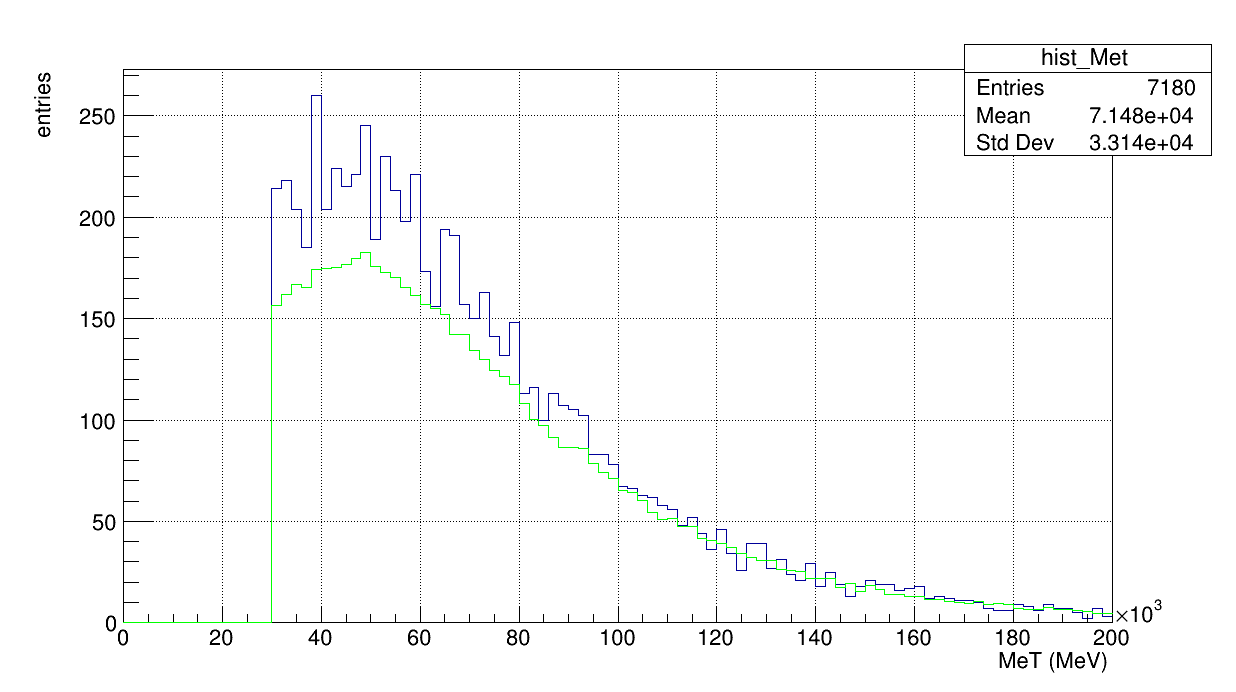

In [ ]:
hist_Met.Draw("hist")
MC_hist_Met.Scale(weight)
MC_hist_Met.SetLineColor(3)
MC_hist_Met.Draw("histsame")
canvas.Draw()

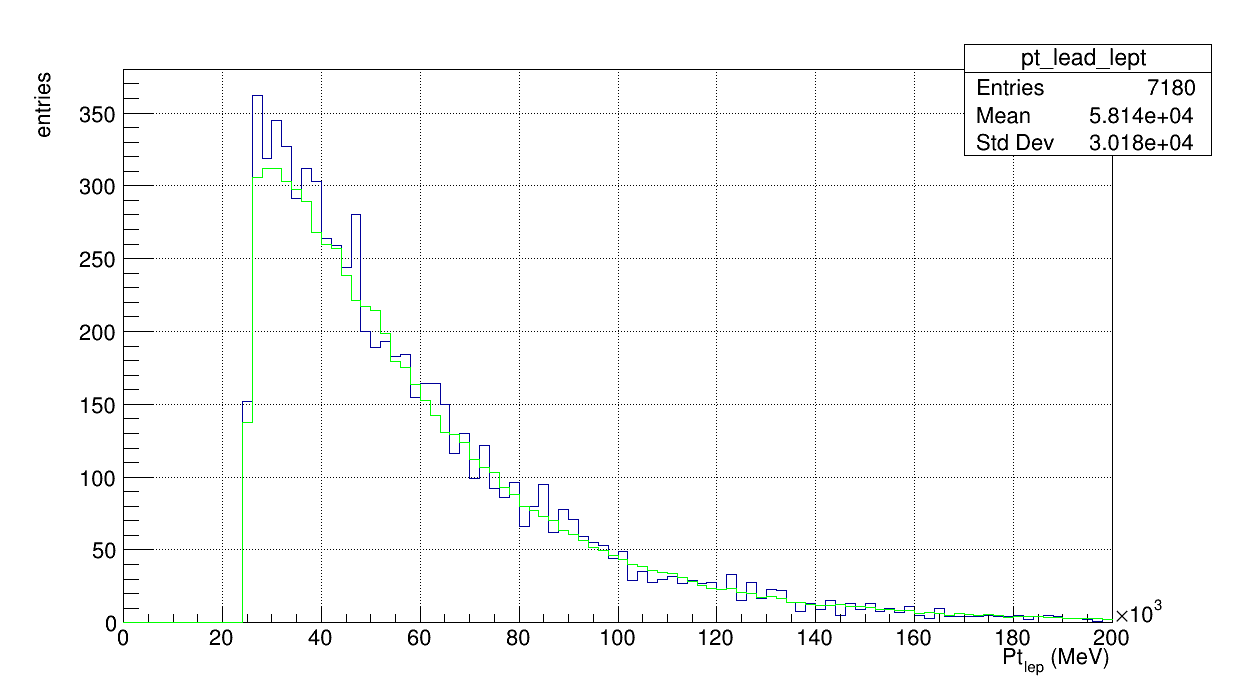

In [ ]:
pt_lead_lept.Draw("hist")
MC_pt_lead_lept.Scale(weight)
MC_pt_lead_lept.SetLineColor(3)
MC_pt_lead_lept.Draw("histsame")
canvas.Draw()

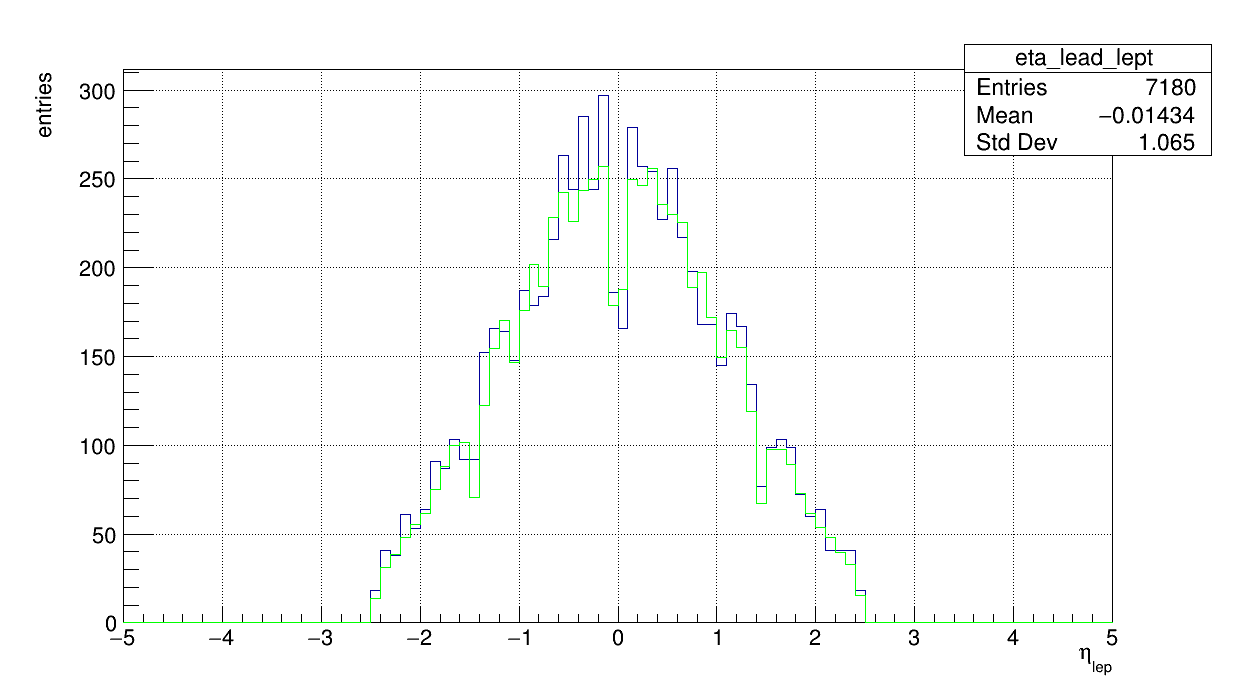

In [ ]:
eta_lead_lept.Draw("hist")
MC_eta_lead_lept.Scale(weight)
MC_eta_lead_lept.SetLineColor(3)
MC_eta_lead_lept.Draw("histsame")
canvas.Draw()

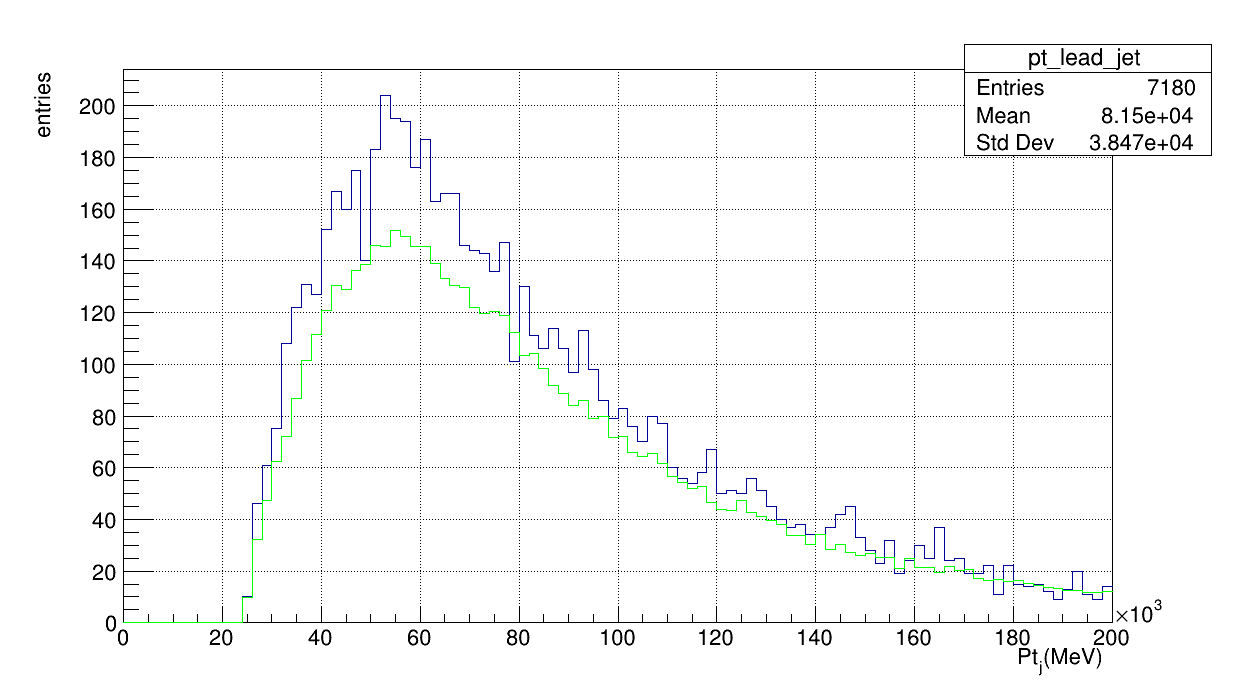

In [ ]:
pt_lead_jet.Draw("hist")
MC_pt_lead_jet.Scale(weight)
MC_pt_lead_jet.SetLineColor(3)
MC_pt_lead_jet.Draw("histsame")
canvas.Draw()

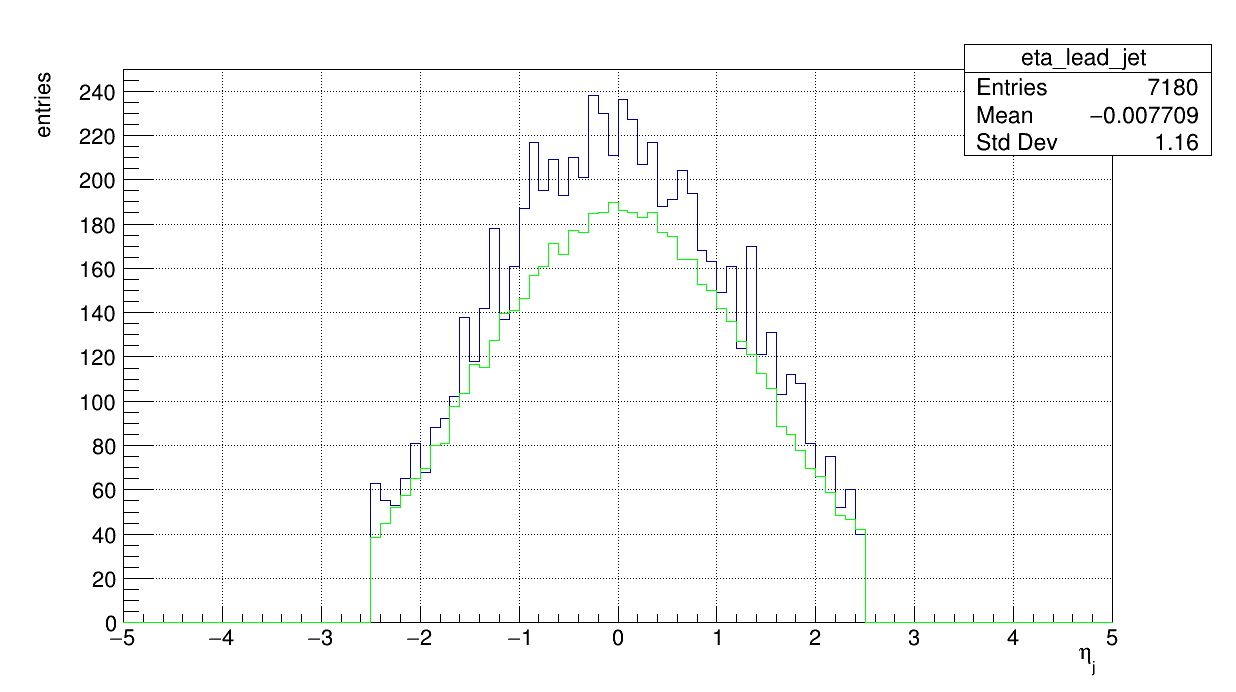

In [ ]:
eta_lead_jet.Draw("hist")
MC_eta_lead_jet.Scale(weight)
MC_eta_lead_jet.SetLineColor(3)
MC_eta_lead_jet.Draw("histsame")
canvas.Draw()

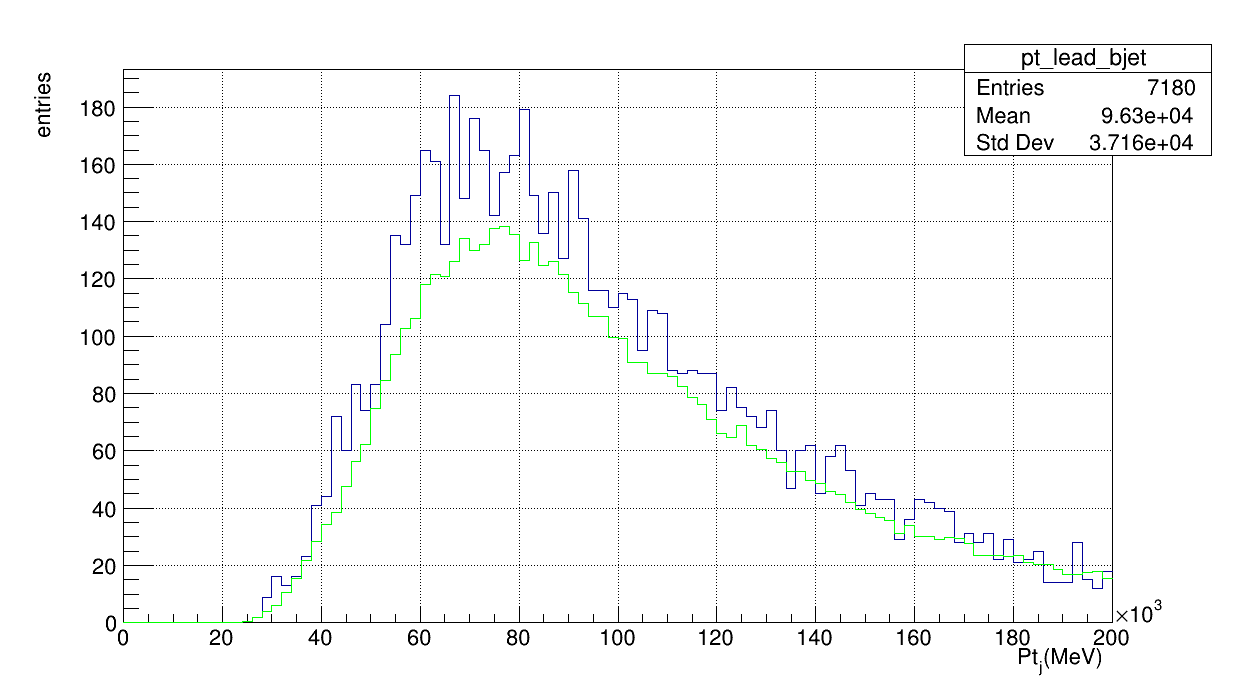

In [ ]:
pt_lead_bjet.Draw("hist")
MC_pt_lead_bjet.Scale(weight)
MC_pt_lead_bjet.SetLineColor(3)
MC_pt_lead_bjet.Draw("histsame")
canvas.Draw()

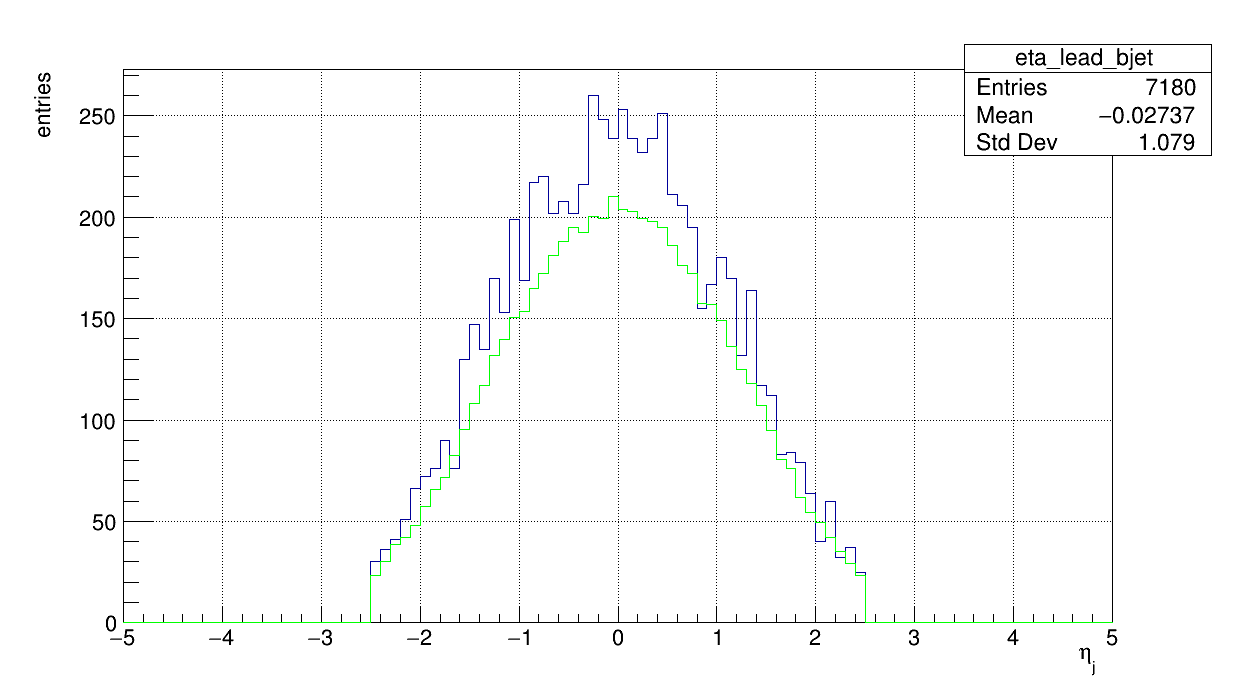

In [ ]:
eta_lead_bjet.Draw("hist")
MC_eta_lead_bjet.Scale(weight)
MC_eta_lead_bjet.SetLineColor(3)
MC_eta_lead_bjet.Draw("histsame")
canvas.Draw()